# Exploring Cook County Housing: Predicting Housing Sale Prices

In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

In [2]:
# Load dataset

with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()
    
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
# 204792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values

In [3]:
print(training_data.columns.values)
print(training_data['Description'][0])

['PIN' 'Property Class' 'Neighborhood Code' 'Land Square Feet' 'Town Code'
 'Apartments' 'Wall Material' 'Roof Material' 'Basement' 'Basement Finish'
 'Central Heating' 'Other Heating' 'Central Air' 'Fireplaces' 'Attic Type'
 'Attic Finish' 'Design Plan' 'Cathedral Ceiling' 'Construction Quality'
 'Site Desirability' 'Garage 1 Size' 'Garage 1 Material'
 'Garage 1 Attachment' 'Garage 1 Area' 'Garage 2 Size' 'Garage 2 Material'
 'Garage 2 Attachment' 'Garage 2 Area' 'Porch' 'Other Improvements'
 'Building Square Feet' 'Repair Condition' 'Multi Code'
 'Number of Commercial Units' 'Estimate (Land)' 'Estimate (Building)'
 'Deed No.' 'Sale Price' 'Longitude' 'Latitude' 'Census Tract'
 'Multi Property Indicator' 'Modeling Group' 'Age' 'Use' "O'Hare Noise"
 'Floodplain' 'Road Proximity' 'Sale Year' 'Sale Quarter' 'Sale Half-Year'
 'Sale Quarter of Year' 'Sale Month of Year' 'Sale Half of Year'
 'Most Recent Sale' 'Age Decade' 'Pure Market Filter' 'Garage Indicator'
 'Neigborhood Code (mapping)

## Dataset Description


### The CCAO Dataset

The dataset comes from the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. More about data collection is listed in the CCAO’s [Residential Data Integrity Preliminary Report](https://gitlab.com/ccao-data-science---modeling/ccao_sf_cama_dev/-/blob/master/documentation/Preliminary%20Report%20on%20Data%20Integrity%20June%207,%202019.pdf). In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing “[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

In this project, I will be building a linear model that predict sales prices using training data but it's important to first understand how the structure of the data informs such a model. In this section, I will make a series of exploratory visualizations and feature engineering in preparation for that prediction task.

Note that we will perform EDA on the **training data**.


# Exploratory Data Analysis

### Sale Price

Each row represents a distinct property – specifically, a specific house at a given address. We are given information on the house's property class, square footage, sale year, geographic latitude and longitude, etc. The granularity of the information available to us in the dataset indicates that we are on the level of individual housing.

I begin by examining the distribution of our target variable `SalePrice`.  At the same time, I also take a look at some descriptive statistics of this variable.

In [4]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)

To zoom in on the visualization of most households, I will focus only on a subset of `Sale Price` for this assignment. I apply a log transformation to `Sale Price` and reassign `training_data` to a new dataframe that is the same as the original one **except with the following changes**:

- `training_data` contains only households whose price is at least $500.
- `training_data` contains a new `Log Sale Price` column that contains the log-transformed sale prices.

In [5]:
training_data = training_data[training_data['Sale Price'] >= 500]
training_data["Log Sale Price"] = np.log(training_data['Sale Price'])

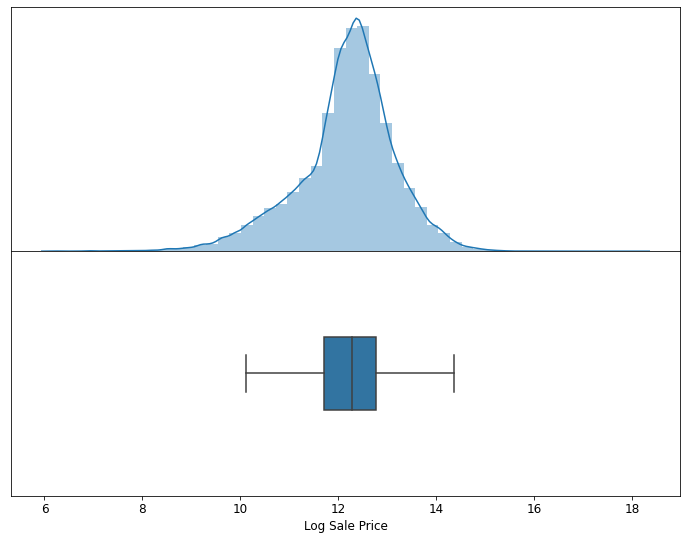

In [6]:
plot_distribution(training_data, label='Log Sale Price');

The distribution of `Log Sale Price` in the training set is symmetric, and at least 25% of the houses in the training set sold for more than \$200,000.00.

Next, I want to explore if any there is any correlation between `Log Sale Price` and the total area occupied by the household `Building Square Feet` -- it measures "(from the exterior) the total area, in square feet, occupied by the building". I create a jointplot to visualize the correlation.

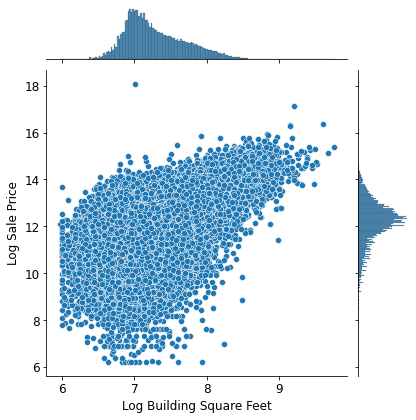

In [7]:
training_data["Log Building Square Feet"] = np.log(training_data["Building Square Feet"])
sns.jointplot(data=training_data, x="Log Building Square Feet", y="Log Sale Price");

In [8]:
# I define a function to remove outliers

def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] <= upper) & (data[variable] >= lower)]

# Feature Engineering

I create a function `add_total_bedrooms(data)` that returns a copy of `data` with an additional column called `Bedrooms` that contains the total number of bedrooms (as integers) for each house.

In [9]:
training_data[["Description"]].iloc[0, 0]

'This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

In [10]:
def add_total_bedrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least the Description column.
    """
    with_rooms = data.copy()
    with_rooms["Bedrooms"] = with_rooms["Description"].str.extract("(\d+) of which are bedrooms", expand=False).astype(int)
    return with_rooms

In [11]:
training_data = add_total_bedrooms(training_data)

I create a violin boxplot to visualize the association between `Bedrooms` and `Log Sale Price`.

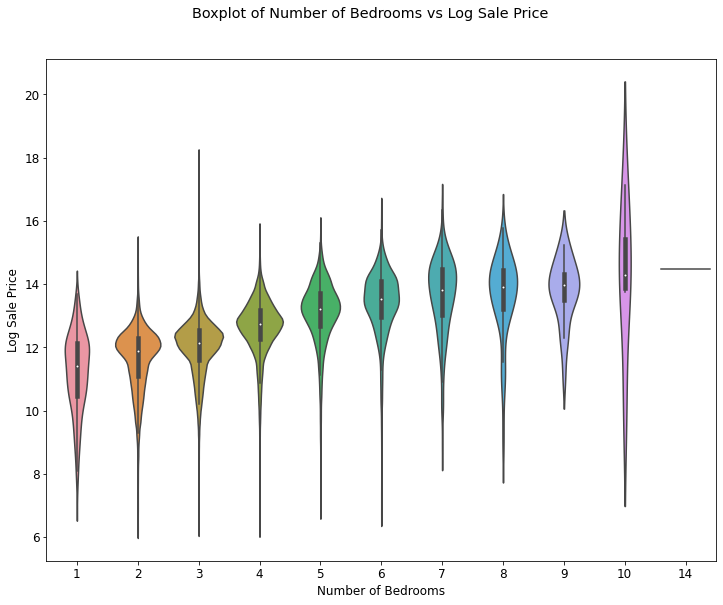

In [12]:
ax = sns.violinplot(
        x='Bedrooms',
        y='Log Sale Price',
        data=training_data,
    )
ax.set(xlabel='Number of Bedrooms', ylabel='Log Sale Price')
plt.suptitle("Boxplot of Number of Bedrooms vs Log Sale Price")
plt.subplots_adjust(top=0.9);

I will now assess the relationship between neighborhood and sale prices of the houses in our data set. For the sake of clarity in visualization and to avoid overplotting, I will only be examining the top 20 neighborhoods in terms of number of houses.

In [13]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

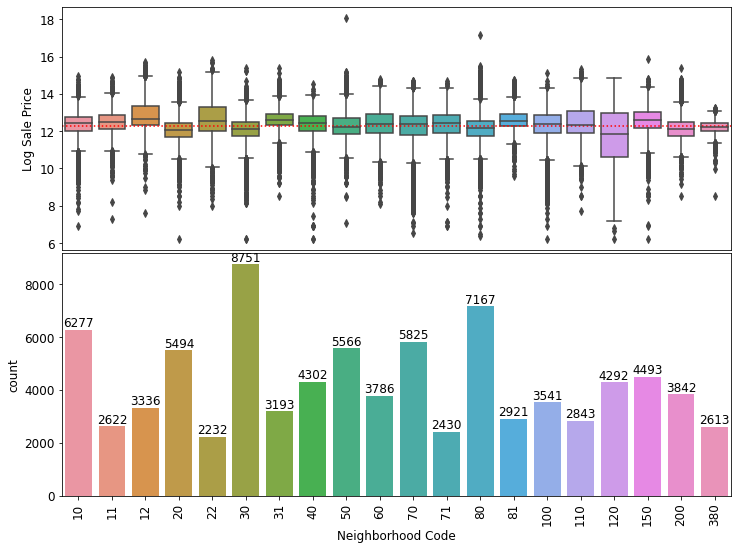

In [14]:
in_top_20_neighborhoods = training_data[training_data["Neighborhood Code"].isin(training_data.groupby("Neighborhood Code").count().sort_values("PIN", ascending=False).index.values[0:20])]
plot_categorical(neighborhoods=in_top_20_neighborhoods)

The twenty neighborhoods with the greatest number of houses have a median `Log Sale Price` of just over 12, which corresponds to a median `Sale Price` of nearly $200,000. From the distribution of sale price within each neighborhood, three out of the top four neighborhoods with the most number of houses all have median sales prices below the overall median. By contrast, nearly all the neigborhoods with the fewest number of houses have median sale prices that are above the overall median sale price.

One way I can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  I categorize neighborhoods in a crude way: I take the top 3 neighborhoods measured by median `Log Sale Price` and identify them as "expensive neighborhoods"; the other neighborhoods are not marked.

`find_expensive_neighborhoods(data, n, metric)` is a function that returns list of the neighborhood codes of the top `n` most pricy neighborhoods as measured by our choice of aggregating function.  For example, I would want to call `find_expensive_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `Log Sale Price`.

In [15]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued 'Neighborhood Code'
        and a numeric 'Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods as measured by the metric function
    """
    neighborhoods = list(training_data.groupby("Neighborhood Code").agg(metric).sort_values("Log Sale Price", ascending=False).loc[:, "Log Sale Price"][0:n].index.values)
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in numpy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

I now have a list of neighborhoods I've deemed as higher-priced than others. I use that information to write a function `add_expensive_neighborhood` that adds a column for a dummy variable `in_expensive_neighborhood` which takes on the value 1 if the house is part of `expensive_neighborhoods` and the value 0 otherwise.

In [16]:
def add_in_expensive_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood Code' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as expensive
    Output:
      data frame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data["Neighborhood Code"].isin(expensive_neighborhoods).astype(int)
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

In the following question, I take a closer look at the `Roof Material` feature of the dataset and examine how to incorporate categorical features into our linear model. The Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Central Heating (Nominal): 

       1	Shingle/Asphalt
       2	Tar&Gravel
       3	Slate
       4	Shake
       5    Tile
       6    Other
```

I write a function `substitute_roof_material` that replaces each numerical value in `Roof Material` with their corresponding roof material.

In [17]:
def substitute_roof_material(data):
    """
    Input:
      data (data frame): a data frame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored 'Roof Material' column
    """
    new_df = data.copy()
    new_df["Roof Material"] = new_df["Roof Material"].replace({1: "Shingle/Asphalt", 2: "Tar&Gravel", 3: "Slate", 4: "Shake", 5: "Tile", 6: "Other"})
    return new_df
    
training_data = substitute_roof_material(training_data)
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0


Since `Roof Material` is a categorical variable, I will one-hot-encode the data.

I define the following function `ohe_roof_material` that returns a dataframe with the new column one-hot-encoded on the roof material of the household. These new columns should have the form `Roof Material_MATERIAL`.

In [18]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material.  New columns are of the form x0_MATERIAL.
    """
    new_df = data.copy()
    oh_enc = OneHotEncoder()
    transformed = oh_enc.fit_transform(data[['Roof Material']])
    new_df[oh_enc.categories_[0]] = transformed.toarray()
    
    new_df = new_df.rename(columns={"Other": "Roof Material_Other", "Shake": "Roof Material_Shake", "Shingle/Asphalt": "Roof Material_Shingle/Asphalt",
                           "Slate": "Roof Material_Slate", "Tar&Gravel": "Roof Material_Tar&Gravel", "Tile": "Roof Material_Tile"})
    
    return new_df

training_data = ohe_roof_material(training_data)
training_data.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar&Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


## Data Pipeline

In [19]:
# This makes the train-test split in this section reproducible across different runs 
# of the notebook.

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    split_point = int(0.8 * data_len)
    train_indices = shuffled_indices[0:split_point]
    test_indices = shuffled_indices[split_point:data_len]
    return data.iloc[train_indices, :], data.iloc[test_indices, :]
train, test = train_test_split(training_data)

The following function `process_data_gm` takes in a dataframe `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). It returns two NumPy arrays: `X`, which is our design matrix, and `y` which is the vector containing the observed data.

In [20]:
def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

In [21]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

Now, I will fit the updated linear regression model using the ordinary least squares estimator. I will start off with something simple by using only 2 features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our 1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, I will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

It is time to prepare the training and validation data for the two models I proposed above.

- I perform a `train_test_split` on the original dataset. Let 80% of the set be training data and 20% of the set be validation data.
- For both the training and validation set, I:
    1. Remove outliers in `Sale Price` by so that we are considering households with a price that is strictly greater than 499 dollars (i.e., greater than or equal to 500 dollars). 
    2. Apply log transformations to `Sale Price` and the `Building Square Feet` columns to create 2 new columns `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` as well if this is the 2nd model).
    5. Return the design matrix $X$ and the observed vector $y$.
    

Finally, I assign the final training data and validation data for both models to the following set of variables:

- 1st Model: `X_train_m1`, `y_train_m1`, `X_test_m1`, `y_test_m1`
- 2nd Model: `X_train_m2`, `y_train_m2`, `X_test_m2`, `y_test_m2`

In [22]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, test_m1 = train_test_split(full_data)

m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]


X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_test_m1, y_test_m1 = process_data_gm(test_m1, m1_pipelines, 'Log Sale Price')

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, test_m2 = train_test_split(full_data)
m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)
]
X_train_m2, y_train_m2 = process_data_gm(train_m2, m2_pipelines, 'Log Sale Price')
X_test_m2, y_test_m2 = process_data_gm(test_m2, m2_pipelines, 'Log Sale Price')

## Regression Model

I first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of my models. I set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [23]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit the linear regression model, which I use to compute the fitted values of `Log Sale Price` over the training data, and the predicted values of `Log Sale Price` for the testing data.

I assign the predicted values from both of my models on the training and testing set to the following variables:

- 1st Model: prediction on training set: `y_fitted_m1`, prediction on testing set: `y_predicted_m1`
- 2nd Model: prediction on training set: `y_fitted_m2`, prediction on testing set: `y_predicted_m2`

In [24]:
# Fit the 1st model
# Compute the fitted and predicted values of Log Sale Price for 1st model
y_fitted_m1 = linear_model_m1.fit(X_train_m1, y_train_m1).predict(X_train_m1)
y_predicted_m1 = linear_model_m1.predict(X_test_m1)

# Fit the 2nd model
# Compute the fitted and predicted values of Log Sale Price for 2nd model
y_fitted_m2 = linear_model_m2.fit(X_train_m2, y_train_m2).predict(X_train_m2)
y_predicted_m2 = linear_model_m2.predict(X_test_m2)

I compare the performance of our two regression models using the Root Mean Squared Error function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

I define the `rmse` function below.

In [25]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

In [26]:
# Training and test errors for the 1st model
training_error_m1 = rmse(y_fitted_m1, y_train_m1)
test_error_m1 = rmse(y_predicted_m1, y_test_m1)

# Training and test errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = rmse(np.exp(y_fitted_m1), np.exp(y_train_m1))
test_error_m1_delog = rmse(np.exp(y_predicted_m1), np.exp(y_test_m1))


# Training and test errors for the 2nd model
training_error_m2 = rmse(y_fitted_m2, y_train_m2)
test_error_m2 = rmse(y_predicted_m2, y_test_m2)


# Training and test errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = rmse(np.exp(y_fitted_m2), np.exp(y_train_m2))
test_error_m2_delog = rmse(np.exp(y_predicted_m2), np.exp(y_test_m2))

print("1st Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1, test_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1_delog, test_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2, test_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2_delog, test_error_m2_delog))

1st Model
Training RMSE: 0.9025651719699077
Test RMSE: 0.9068644732045896

1st Model (no log transform)
Training RMSE: 382697.78149699024
Test RMSE: 310679.248661157

2nd Model
Training RMSE: 0.8042009333446841
Test RMSE: 0.8113963052434994

2nd Model (no log transform)
Training RMSE: 325716.40819160384
Test RMSE: 254880.4222850615



In [27]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ0: {}\nθ1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ0: {}\nθ1: {}\nθ2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ0: 10.571725401040084
θ1: 0.49691974631414415
2nd Model
θ0: 1.9339633173823856
θ1: -0.03064724980355341
θ2: 1.4170991378689615


Another way of understanding the performance (and appropriateness) of a model is through a plot of the model the residuals versus the observations.

In the cell below, I use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the residuals from predicting `Log Sale Price` using **only the 2nd model** against the original `Log Sale Price` for the **test data**.

Text(0, 0.5, 'Prediction Error')

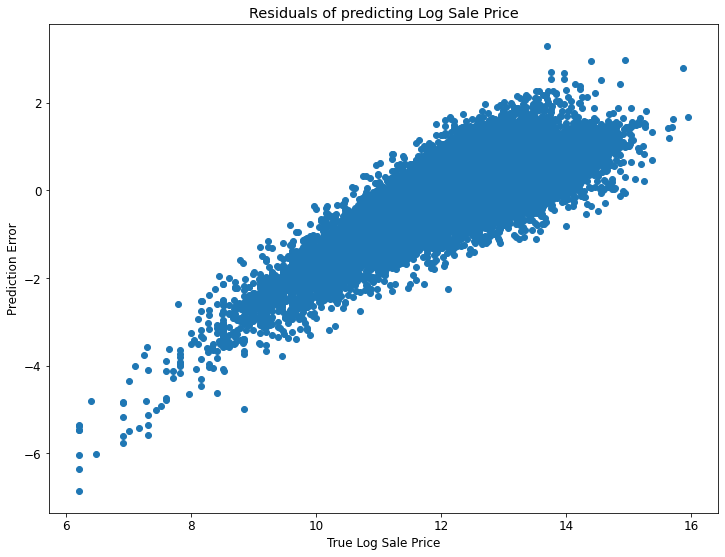

In [28]:
plt.scatter(y_test_m2, y_test_m2 - y_predicted_m2)
plt.title("Residuals of predicting Log Sale Price")
plt.xlabel("True Log Sale Price")
plt.ylabel("Prediction Error")

Based on the structure I see in the plot, this model seem like it will correspond to _regressive_ taxation.

## Updating Model with More Features

In [29]:
def run_linear_regression_test(
    final_model, 
    process_data_fm, 
    threshold, 
    train_data_path, 
    test_data_path, 
    is_kaggle=False, 
    is_ranking=False
):
    def rmse(predicted, actual):
        return np.sqrt(np.mean((actual - predicted)**2))

    training_data = pd.read_csv(train_data_path, index_col='Unnamed: 0')
    X_train, y_train = process_data_fm(training_data)
    if is_kaggle:
        test_data = pd.read_csv(test_data_path, index_col='Unnamed: 0')
        X_test, y_test = process_data_fm(test_data)

    final_model.fit(X_train, y_train)
    if is_kaggle:
        y_predicted = final_model.predict(X_test)
        loss = rmse(np.exp(y_predicted), np.exp(y_test))
    else:
        y_predicted = final_model.predict(X_train)
        loss = rmse(np.exp(y_predicted), np.exp(y_train))
    if is_ranking:
        print('Your RMSE loss is: {}'.format(loss))
        return loss
    return loss < threshold

def run_linear_regression_test_optim(
    final_model, 
    process_data_fm, 
    train_data_path, 
    test_data_path, 
    is_test=False, 
    is_ranking=False,
    return_predictions=False
):
    def rmse(predicted, actual):
        return np.sqrt(np.mean((actual - predicted)**2))

    training_data = pd.read_csv(train_data_path, index_col='Unnamed: 0')
    X_train, y_train = process_data_fm(training_data)
    if is_test:
        test_data = pd.read_csv(test_data_path, index_col='Unnamed: 0')
        X_test = process_data_fm(test_data, is_test_set = True)
        assert len(test_data) == len(X_test), 'You may not remove data points from the test set!'

    final_model.fit(X_train, y_train)
    if is_test:
        return final_model.predict(X_test)
    else:
        y_predicted = final_model.predict(X_train)
        loss = rmse(np.exp(y_predicted), np.exp(y_train))
        if is_ranking:
            print('Your RMSE loss is: {}'.format(loss))
            return loss
        fn = (lambda threshold: loss < threshold)
        fn.loss = loss
        fn.signature = (process_data_fm, train_data_path, test_data_path)
        return fn

def process_data_fm(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # do your processing for the training set (i.e. not the test set)
        # this can involve references to sale price!
        iqr = data['Estimate (Building)'].quantile(0.75) - data['Estimate (Building)'].quantile(0.25)
        data = remove_outliers(data, 'Estimate (Building)', upper=data['Estimate (Building)'].quantile(0.75) + 1.5*iqr, lower=data['Estimate (Building)'].quantile(0.75) - 1.5*iqr)
        data = remove_outliers(data, 'Sale Price', upper=data['Sale Price'].quantile(0.75) + 1.5*iqr, lower=data['Sale Price'].quantile(0.75) - 1.5*iqr)
        data['Log Sale Price'] = np.log(data['Sale Price'])
        data['Log Age'] = np.log(data['Age'] + 1)
        data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'] + 1)
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'] + 1)
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'] + 1)
        data = data[['Sale Year', 'Town Code', 'Log Age', 'Log Estimate (Building)', 'Log Building Square Feet', 'Latitude', 'Longitude', 'Log Sale Price']] 
    else:
        data['Log Age'] = np.log(data['Age'] + 1)
        data['Log Estimate (Building)'] = np.log(data['Estimate (Building)'] + 1)
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'] + 1)
        data = data[['Sale Year', 'Town Code', 'Log Age', 'Log Estimate (Building)', 'Log Building Square Feet', 'Latitude', 'Longitude']] 
        # do your processing for the test set
        # this CANNOT involve references to sale price!

    # Return predictors and response variables separately
    if is_test_set:
        X = data
        return X
    else:
        X = data.drop(['Log Sale Price'], axis = 1)
        y = data.loc[:, 'Log Sale Price']
        return X, y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_fm, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 69317.28334304699


## Findings

Error for an individual homeowner would mean that their house's value would be assessed either higher or lower than what it actually is depending on the model's prediction. If the error is negative - i.e., if the home's sale price is predicted to be higher than it actually is - the homeowner would have to pay more in property taxes. If the error is positive - i.e., if the home's sale price is predicted to be lower than it actually is - the homeowner would have to pay less in property taxes. Depending on how whether the property tax system is structured, these errors could have different tax implications. If there was a flat property tax, then homeowners would pay a constant proportion of their property value in income regardless of how it was assessed. If there was a progressive tax bracket structure, errors in property value assessment may result in a homeowner having to pay higher marginal tax rates if their property is valued in a bracket higher than what it truly is. This would result in a higher effective tax rate than what would even be present in a flat tax structure.

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. But fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).

Additionally, in their approach to fair property valuations, the CCAO has also pushed for transparency initiatives in the property tax assessment system. After a lawsuit was filed against the CCAO for producing [“racially discriminatory assessments and taxes,"](https://harris.uchicago.edu/news-events/news/prof-chris-berry-testifies-institutional-racism-cook-county-property-taxes) the Office decided that these inequities would be best addressed by making the assessment process more transparent to Cook County constituents.  

These transparency initiatives include publishing all of the CCAO’s work on [GitLab](https://gitlab.com/ccao-data-science---modeling). By allowing the public to access any updates to the system in real-time, the Office argues that they increase accessibility to a process that had previously been blackboxed - obscured and hidden - from the public. Ultimately, the hope is that, by exposing the inner workings of the CCAO’s property valuation process, the CCAO's assessment results could be publicly verified as accurate and therefore trusted to be fair.